In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from copy import deepcopy
##-------------------------------PRE PROCESSING---------------------------------##
## meshing --------------------------------------------------------
class setup:
    def __init__(self,nelx,nely,width,heigth,E,nu):
        self.el_width= width/nelx 
        self.el_heigth= heigth/nely
        self.heigth=heigth
        self.width=width
        self.E=E
        self.nu=nu
        self.nelx=nelx
        self.nely=nely
        self.nnodes=(nelx+1)*(nely+1)
        self.nels=nelx*nely
        self.p=10*E/(self.el_width*(1-nu**2))  
        
        self.coordx=np.linspace(0,width,nelx+1)
        self.coordy=np.insert(np.linspace(0,heigth,nely+1), int(nely/2)+1, heigth/2)
        coord=np.zeros(((nelx+1)*(nely+2),2))
        etpl=np.zeros(((nelx)*(nely),4))
        all_dofs= np.arange((nelx+1)*(nely+2)*2)
        
        # calculate coordinates of global nodes :
        idx=0
        for j in range(nely+2):
            for i in range(nelx+1):
                coord[idx,:]=np.array([self.coordx[i],self.coordy[j]])
                idx=idx+1        
        # calculate connectivity matrix etpl :
        idx=0
        etplall_bot=np.arange((1+int(nely/2))*(1+nelx)).reshape(1+int(nely/2),nelx+1)
        etplall_top=np.arange((1+int(nely/2))*(1+nelx)).reshape(1+int(nely/2),nelx+1)+np.max(etplall_bot)+1
        for i in range(int(nely/2)):
            for j in range(nelx):        
                 etpl[idx]=np.array([etplall_bot[i,j],etplall_bot[i,j+1],etplall_bot[i+1,j+1],etplall_bot[i+1,j]])
                 idx=idx+1

        for i in range(int(nely/2)):
            for j in range(nelx):        
                 etpl[idx]=np.array([etplall_top[i,j],etplall_top[i,j+1],etplall_top[i+1,j+1],etplall_top[i+1,j]])
                 idx=idx+1   
        etpl=etpl.astype(int)

        
        self.etpl=etpl
        self.coord=coord
        self.all_dofs=all_dofs

        self.D=E/(1-nu**2)*np.array([[1,nu,0],[nu,1,0],[0,0,(1-nu)/2]])
        self.allgp=(1/3)**0.5*np.array([[-1,1,1,-1],[-1,-1,1,1]])
        self.J=np.array([[(0.5*width/nelx)/1,0],[0,(0.5*heigth/nely)/1]])
        self.Det=np.linalg.det(self.J)
##------------------------------- PROCESSING ------------------------------------##
## shape functions derivatives matrix -------------------------
    def N(self,x,y):
        n1=1/4 * (x-1)*(y-1)
        n2=-1/4  * (x+1)*(y-1)
        n3=1/4 * (x+1)*(y+1)    
        n4=-1/4 * (x-1)*(y+1)
        output=np.array([[n1,0,n2,0,n3,0,n4,0],[0,n1,0,n2,0,n3,0,n4]])
        return output
   ## derivatives matrix  :
    def B(self,x,y):
        output= 1/4 * \
                np.array([[y-1,0,1-y,0,y+1,0,-1-y,0], \
                          [0,x-1,0,-1-x,0,x+1,0,1-x], \
                     [x-1,y-1,-1-x,1-y,x+1,y+1,1-x,-1-y]])
        output[0,:]=output[0,:]/(self.el_width/2) 
        output[1,:]=output[1,:]/(self.el_heigth/2)
        output[2,::2]=output[2,::2]/(self.el_heigth/2)
        output[2,1::2]=output[2,1::2]/(self.el_width/2)
        return output

## element stiffness matrix ----------------------------------------------------
    def ke(self):
        kei=np.zeros((8,8))
        for gp in range(4):
            x=self.allgp[0,gp]
            y=self.allgp[1,gp]
            kei=kei+1*self.Det*np.matmul(np.transpose(self.B(x,y)),np.matmul(self.D,self.B(x,y)))
        return kei

    def me(self):
        mei=np.zeros((8,8))
        for gp in range(4):
            x=self.allgp[0,gp]
            y=self.allgp[1,gp]
            mei=mei+1*1200*self.Det*(np.transpose(self.N(x,y))@self.N(x,y))
        return mei

    def kbase(self):
        Kbase=np.zeros(((self.nelx+1)*(self.nely+2)*2,(self.nelx+1)*(self.nely+2)*2))
        ke=self.ke() #put at the begining to call it only once
        etpl=self.etpl
        for i in range(self.nels): #nels
            for row in range(4):
                for col in range(4):
                    indr=etpl[i][row]*2; indc=etpl[i][col]*2
                    Kbase[indr:(indr+2),indc:(indc+2)]=Kbase[indr:(indr+2),indc:(indc+2)] + \
                                                   ke[row*2:(row*2+2),col*2:(col*2+2)]
        return Kbase

    def mbase(self):
        Mbase=np.zeros(((self.nelx+1)*(self.nely+2)*2,(self.nelx+1)*(self.nely+2)*2))
        me=self.me() #put at the begining to call it only once
        etpl=self.etpl
        for i in range(self.nels): #nels
            for row in range(4):
                for col in range(4):
                    indr=etpl[i][row]*2; indc=etpl[i][col]*2
                    Mbase[indr:(indr+2),indc:(indc+2)]=Mbase[indr:(indr+2),indc:(indc+2)] + \
                                                   me[row*2:(row*2+2),col*2:(col*2+2)]
        return Mbase

## Processing functions -----------------------------------------
class output_static:
    def __init__(self,setup,Kbase,BC_dofs,BC_val,P_horiz,P_vert,d1,d2,p,cond,F_int):
        coord=setup.coord
        D=setup.D
        nu=setup.nu
        E=setup.E
        heigth=setup.heigth
        width=setup.width
        nelx=setup.nelx
        nely=setup.nely
        all_dofs=setup.all_dofs

        ## you can re-run this part after having chosen different values of stress with picking
        K=deepcopy(Kbase)

 ### in case we need the theoretical deforation of a rectangular solid:
        exx=nu*np.average(P_vert)/E; # strain in horizontal direction
        eyy=np.average(P_vert)/E; # strain in vertical direction
        dxy=heigth*np.average(P_horiz)/(E/(2*(1+nu))) # shear displacement (horizontal direction)


        ## initialize force vector
        F=np.zeros(((nelx+1)*(nely+2)*2,1))

        ## assemble degrees of freedom
        bot_nodes=np.where(coord[:,1]==0)[0]
        dofs0=bot_nodes*2  # dofs x direction
        dofs1=bot_nodes*2+1  # dofs y direction 
        right_nodes=np.where(coord[:,0]==width)[0]
        dofs2=right_nodes*2  # dofs x direction
        dofs3=right_nodes*2+1  # dofs y direction         
        top_nodes=np.where(coord[:,1]==heigth)[0]
        dofs4=top_nodes*2  # dofs x direction
        dofs5=top_nodes*2+1  # dofs y direction 
        left_nodes=np.where(coord[:,0]==0)[0]
        dofs6=left_nodes*2  # dofs x direction
        dofs7=left_nodes*2+1  # dofs y direction 

        #extra_dofs:
        nodes_11=np.where(coord[:,0]==0)[0]
        nodes_12=np.where(coord[nodes_11,1]<=d1)[0]
        nodes_1=nodes_11[nodes_12]
        dofs8=nodes_1*2  # dofs x direction
        dofs9=nodes_1*2+1  # dofs y direction

        nodes_21=np.where(coord[:,0]==width)[0]
        nodes_22=np.where(coord[nodes_21,1]>=(heigth-d2))[0]
        nodes_2=nodes_21[nodes_22]
        dofs10=nodes_2*2  # dofs x direction
        dofs11=nodes_2*2+1  # dofs y direction
        
        dofs_BC=[dofs0,dofs1,dofs2,dofs3,dofs4,dofs5,dofs6,dofs7,dofs8,dofs9,dofs10,dofs11] ##all dofs on Boundaries as shown on drawing
        # +4 extra dofs groups
        
        nmn_dofs=np.concatenate(np.array(dofs_BC)[BC_dofs[1]])
        f=[];
        for expr in BC_val[1]:  
            f=np.concatenate((f,eval(expr)))
        F[nmn_dofs,0]=f
        
#         #==============add interface forces===============#
        int_nodes=(np.where(coord[:,1]==(heigth/2))[0])
        dofs_int=np.append(int_nodes*2,int_nodes*2+1).reshape(4,(nelx+1))
        self.dofs_int=dofs_int
#         #=================or add springs==================#
        
        if cond=='penalty':
            for i,j in zip(np.append(dofs_int[0,:],dofs_int[2,:]), \
                           np.append(dofs_int[1,:],dofs_int[3,:])):
                K[i,j]=K[i,j]-p
                K[j,i]=K[j,i]-p
                K[i,i]=K[i,i]+p
                K[j,j]=K[j,j]+p   
        else:
            for i,j in zip(dofs_int[2,:],dofs_int[3,:]):
                K[i,j]=K[i,j]-p
                K[j,i]=K[j,i]-p
                K[i,i]=K[i,i]+p
                K[j,j]=K[j,j]+p 
                
            fint = np.transpose(np.array([eval(F_int)]))
            F[dofs_int[1,:]]=-fint
            F[dofs_int[0,:]]=fint
            
           #=================Displacement BCs==================# 
        d=[];
        for expr in BC_val[0]:
            d=np.concatenate((d,eval(expr)))

        fixed_dofs=np.concatenate(np.array(dofs_BC)[BC_dofs[0]])
        free_dofs=all_dofs[np.in1d(all_dofs, fixed_dofs,invert=True)]

        for id in range(len(fixed_dofs)):
            i=fixed_dofs[id];
            rows=K[free_dofs,i];
            F[free_dofs,0]=F[free_dofs,0]-rows*d[id];
            K[:,i]=0; K[i,:]=0; K[i,i]=1;
            F[i]=d[id];

        ## solve the system with a sparse matrix ------------------------------------------
        Ksp = csr_matrix(K)
        U= spsolve(Ksp,F)
        self.U=U
        
        self.force_int=(U[dofs_int[1,:]]-U[dofs_int[0,:]])*p
        
def D(E,nu):
    return E/(1-nu**2)*np.array([[1,nu,0],[nu,1,0],[0,0,(1-nu)/2]])

        ##-------------------------------POST PROCESSING------------------------------------##
        ## Calculate stresses ----------------------------------------------------------------
#         sigma=np.zeros((nely+1,nelx+1,3))
#         ux_mat=U[::2].reshape((nely+1, nelx+1))
#         uy_mat=U[1::2].reshape((nely+1, nelx+1))
#         Du=np.gradient(ux_mat,setup.el_heigth,setup.el_width);
#         Dv=np.gradient(uy_mat,setup.el_heigth,setup.el_width);
#         Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
#         for i in range(nely+1):
#             for j in range(nelx+1):
#                 strain=np.matmul(Bstress,np.array([[Du[1][i,j]],[Dv[0][i,j]],[Dv[1][i,j]],[Du[0][i,j]]]));
#                 stress=np.matmul(D,strain);
#                 sigma[i,j,0]=stress[0]; # 0 for syy
#                 sigma[i,j,1]=stress[1]; # 1 for sxx
#                 sigma[i,j,2]=stress[2]; # 2 for tauxy
        
        
#         self.sigma=sigma
#         self.shear_half=sigma[:,:,2][int(nely/2+1),:]
#         self.normal_half=sigma[:,:,1][int(nely/2+1),:]
#         self.shear_top=sigma[:,:,2][int(nely),:]
#         self.Ux_grid=(coord[:,0]+U[::2]).reshape((nely+1, nelx+1))
#         self.Uy_grid=(coord[:,1]+U[1::2]).reshape((nely+1, nelx+1))
## functions to plot photoelastic fringe pattern
def Tmax_mixed(sigma):
    output = np.sqrt(((sigma[:,:,0]- \
                       sigma[:,:,1])/2)**2 + \
                       sigma[:,:,2]**2 )
    return output

## Fringe number
def N_frg(sigma,h,fs):
    output = Tmax_mixed(sigma) * 2 * h / fs  
    #( if we multiply by * np.sqrt(2) it fits kamulu & kobayashi)
    return output

def Inty(sigma,h,fs):
    return np.sin(N_frg(sigma,h,fs) * np.pi)**2

def onclick(event):
    global ix, iy
    
    ix, iy = event.xdata, event.ydata
    print ('x = %d, y = %d'%(
        ix, iy))
    
    global yp
    global xp
    
    if event.button==3:
        yp.append(iy)
        xp.append(ix)
        print(np.round(np.array(yp),2))
        print(np.round(np.array(xp),2))
 #       zp_i=raw_input('fringe values?') not working...
        
    if event.button==2:
        xp=[]
        yp=[]

    return [xp,yp]

### dynamic solver:
class output_dyn:
    def __init__(self,setup,K,Mbase_inv,BC_dofs,BC_val,P_horiz,P_vert,d1,d2,p,cond,F_int,Utold,Ut,dt,force,condrup,it):
        coord=setup.coord
        D=setup.D
        nu=setup.nu
        E=setup.E
        heigth=setup.heigth
        width=setup.width
        nelx=setup.nelx
        nely=setup.nely
        all_dofs=setup.all_dofs

        ## you can re-run this part after having chosen different values of stress with picking
#         K=deepcopy(Kbase)

 ### in case we need the theoretical deforation of a rectangular solid:
        exx=nu*np.average(P_vert)/E; # strain in horizontal direction
        eyy=np.average(P_vert)/E; # strain in vertical direction
        dxy=heigth*np.average(P_horiz)/(E/(2*(1+nu))) # shear displacement (horizontal direction)


        ## initialize force vector
        F=np.zeros(((nelx+1)*(nely+2)*2,1))

        ## assemble degrees of freedom
        bot_nodes=np.where(coord[:,1]==0)[0]
        dofs0=bot_nodes*2  # dofs x direction
        dofs1=bot_nodes*2+1  # dofs y direction 
        right_nodes=np.where(coord[:,0]==width)[0]
        dofs2=right_nodes*2  # dofs x direction
        dofs3=right_nodes*2+1  # dofs y direction         
        top_nodes=np.where(coord[:,1]==heigth)[0]
        dofs4=top_nodes*2  # dofs x direction
        dofs5=top_nodes*2+1  # dofs y direction 
        left_nodes=np.where(coord[:,0]==0)[0]
        dofs6=left_nodes*2  # dofs x direction
        dofs7=left_nodes*2+1  # dofs y direction 

        #extra_dofs:
        nodes_11=np.where(coord[:,0]==0)[0]
        nodes_12=np.where(coord[nodes_11,1]<=d1)[0]
        nodes_1=nodes_11[nodes_12]
        dofs8=nodes_1*2  # dofs x direction
        dofs9=nodes_1*2+1  # dofs y direction

        nodes_21=np.where(coord[:,0]==width)[0]
        nodes_22=np.where(coord[nodes_21,1]>=(heigth-d2))[0]
        nodes_2=nodes_21[nodes_22]
        dofs10=nodes_2*2  # dofs x direction
        dofs11=nodes_2*2+1  # dofs y direction
        
        dofs_BC=[dofs0,dofs1,dofs2,dofs3,dofs4,dofs5,dofs6,dofs7,dofs8,dofs9,dofs10,dofs11] ##all dofs on Boundaries as shown on drawing
        # +4 extra dofs groups
        
        nmn_dofs=np.concatenate(np.array(dofs_BC)[BC_dofs[1]])
        f=[];
        for expr in BC_val[1]:  
            f=np.concatenate((f,eval(expr)))
        F[nmn_dofs,0]=f
        
#         #==============add interface forces===============#
        int_nodes=(np.where(coord[:,1]==(heigth/2))[0])
        dofs_int=np.append(int_nodes*2,int_nodes*2+1).reshape(4,(nelx+1))
        self.dofs_int=dofs_int
#         #=================or add springs==================#
        
        if it==0: #add the srpings only at the begining
            for i,j in zip(np.append(dofs_int[0,:],dofs_int[2,:]), \
                           np.append(dofs_int[1,:],dofs_int[3,:])):
                K[i,j]=K[i,j]-p
                K[j,i]=K[j,i]-p
                K[i,i]=K[i,i]+p
                K[j,j]=K[j,j]+p   
            
        dofs_condrup=dofs_int[:,condrup[0]] 
        for i,j in zip(dofs_condrup[0,:],dofs_condrup[1,:]):
            K[i,j]=K[i,j]+p
            K[j,i]=K[j,i]+p
            K[i,i]=K[i,i]-p
            K[j,j]=K[j,j]-p 
            
        fint=np.transpose(np.array([F_int]))
        F[dofs_int[1,:]]=-fint
        F[dofs_int[0,:]]=+fint   
           #=================Displacement BCs==================# 
        d=[];
        for expr in BC_val[0]:
            d=np.concatenate((d,eval(expr)))
   
        fixed_dofs=np.concatenate(np.array(dofs_BC)[BC_dofs[0]])
        free_dofs=all_dofs[np.in1d(all_dofs, fixed_dofs,invert=True)]

        for id in range(len(fixed_dofs)):
            i=fixed_dofs[id];
            rows=K[free_dofs,i];
            F[free_dofs,0]=F[free_dofs,0]-rows*d[id];
            K[:,i]=0; K[i,:]=0; K[i,i]=1;
            F[i]=d[id];

        self.Kout=K    
        ## solve the system ------------------------------------------
        self.Utnew=2*Ut-Utold+dt**2*(Mbase_inv@(F[:,0]-np.transpose(K)@Ut))
        
        
        self.force_tg=(Ut[dofs_int[1,:]]-Ut[dofs_int[0,:]])*p/(width/nelx)
        self.force_norm=(Ut[dofs_int[3,:]]-Ut[dofs_int[2,:]])*p/(width/nelx)

In [8]:
%matplotlib notebook
setup1=setup(60,30,0.30,0.15,3.0e9,0.35)
#plt.imshow(setup1.mbase())
P_horiz=-1.2e6*setup1.el_width
P_vert=-4e6*setup1.el_width
##-------Boundary conditions------------
BC_dofs=[[0,1],[5,4]] #we always give the displacements first, then the forces
## here all the BC values must be expression giving vectors
## to give pressure we must normalize in those expressions 
## by th length of elements (height or width)
BC_val=[['0.0*np.ones((len(dofs0)))', \
         '0.0*np.ones((len(dofs1)))'], \
        ['P_vert*np.ones((len(dofs5)))', \
         'P_horiz*np.ones((len(dofs4)))']]
### results we need to plot solution:
d1=0.0;d2=0.0

F_int='1e6*np.ones((len(dofs_int[0,:])))'
output1=output_static(setup1,setup1.kbase(),BC_dofs,BC_val,P_horiz,P_vert,d1,d2,setup1.p,'penalty',F_int)

<IPython.core.display.Javascript object>


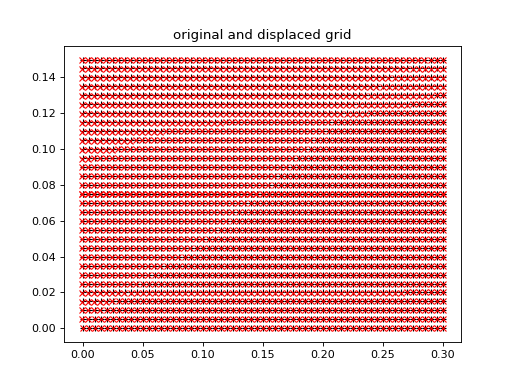

In [9]:
## Boundary conditions ----------------------------------------------------------      

#      --4/5--# 10/11  even numbers -> horizontal dofs
#      |      |   odd numbers -> vert dofs
#      6/7   2/3
#      |      |
# 8/9  --0/1--#

U=output1.U
coord=setup1.coord
f42=plt.figure(42)
ax42=f42.add_subplot(111)
#ax3.quiver(coord[:,0],coord[:,1],U[::2],U[1::2])
ax42.plot(coord[:,0],coord[:,1],'+k')
ax42.plot(coord[:,0]+U[::2],coord[:,1]+U[1::2],'xr') #U[::2,0] if not using sparse
ax42.set_title('original and displaced grid')

In [10]:
output2=output_static(setup1,setup1.kbase(),BC_dofs,BC_val,P_horiz,P_vert,d1,d2,setup1.p,'penalty1','output1.force_int')

In [11]:
def friction_sl(d0,condfric,tan_disp_i,fint,p,width):
    f_init=2e6*width
    f_final=1.5e6*width
    Dc=1e-5
    if len(fint[condfric[0]]>0):
        fint[condfric[0]] = -(f_init-(f_init-f_final)*np.abs((tan_disp_i[0][condfric[0]]-d0[condfric[0]])/Dc))
        fint[np.where(np.logical_and(fint>=-f_final,fint!=0))]=-f_final ##carefu~l with the sign and >= or <=
    return fint

In [12]:
## Boundary conditions ----------------------------------------------------------      

#      --4/5--  10/11  even numbers -> horizontal dofs
#      |      |   odd numbers -> vert dofs
#      6/7   2/3
#      |      |
# 8/9  --0/1-- 

## We need the values of displacement at time steps n-1 and n
## in order to calculate the displacement a time n+1
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import time
%matplotlib notebook
E=setup1.E
nu=setup1.nu
nelx=setup1.nelx
nely=setup1.nely
## simulation parameters and initialisation ===============#
tmax=0.4e-3
rho=1200.0;
G=E/(2*(1+nu));
vs=(G/rho)**0.5;
vp=((2*G*(1-nu))/(rho*(1-2*nu)))**0.5;

dt=0.01/(vp*np.sqrt(1/setup1.el_width**2+1/setup1.el_heigth**2)); #timestep according to courant stability criterion
t=np.linspace(0,tmax,np.round(tmax/dt));nt=len(t);

##===========print the simulation parameters=====================#
total_time=np.max(t)
total_force=P_horiz*2*0.55
loading_rate=total_force/total_time # for uniform displacement rate
print('loading rate = ' + str(loading_rate) + '[m/s]')
print('total time = ' + str(total_time) + '[s]')
print('nb of iterations = ' + str(nt))
print('time step = ' + str(dt) + '[s]')
print('distance reached by S-waves = ' + str(total_time*vs*100) + '[cm]')
print('time to reach interface = ' + str(0.075/vs) + '[s]')
force_all=np.linspace(0,total_force,nt)
##use the static displacement as initial conditions:
Utold=output1.U
Ut=output1.U
## explicit time-stepping scheme==================#
plt.close('all')
# f4=plt.figure(4)
# ax4=f4.add_subplot(111)
# f4.show()
# f4.canvas.draw()
plt.ion()

# from progress.bar import Bar
# bar = Bar('Processing', max=nt)
disp_stored=np.array([Ut])
tan_disp=np.array([Ut[output1.dofs_int[1,:]]-Ut[output1.dofs_int[0,:]]])
condrup=np.where((tan_disp[0]*setup1.p/setup1.el_width)<=-15e6)
print(condrup)
condfric=condrup
fint=output1.force_int*0
d0=output1.force_int*0
Kdyn=setup1.kbase()
Mdyn=np.linalg.inv(setup1.mbase())
p=setup1.p
width=setup1.el_width
BC_dofs=[[0,1],[5,4]] #we always give the displacements first, then the forces
BC_val=[['0.0*np.ones((len(dofs0)))', \
             '0.0*np.ones((len(dofs1)))'], \
            ['P_vert*np.ones((len(dofs5)))', \
             'P_horiz*np.ones((len(dofs4)))+force']]
## check how to impose a fixed displacement, if the mass matrix has to be modified for instance??
for it in range(nt):
    force=force_all[it]
    output3=output_dyn(setup1,Kdyn,Mdyn,BC_dofs,BC_val,P_horiz,P_vert,d1,d2,p, \
                       'penalty',fint,Utold,Ut,dt,force,condrup,it)
    Utnew=output3.Utnew
    Utold=Ut;
    Ut=Utnew;
    
    tan_disp_i=np.array([(Utnew[output3.dofs_int[1,:]]-Utnew[output3.dofs_int[0,:]])])
    condrup=np.where(np.logical_and((tan_disp_i[0]*setup1.p/setup1.el_width)<=-2e6,fint==0))
    condfric=np.where((tan_disp_i[0]*setup1.p/width)<=-2e6)

#     fint[condrup]= tan_disp_i[0][condrup]*setup1.p
    d0[condrup]= tan_disp_i[0][condrup]
    fint= friction_sl(d0,condfric,tan_disp_i,fint,p,width)
    Kdyn=output3.Kout
    if it % 100 ==0:
        print(t[it])
        disp_stored=np.append(disp_stored,np.array([Utnew]),axis=0)
        tan_disp=np.append(tan_disp,tan_disp_i,axis=0)
#         ax4.clear()
#         ax4.plot(setup1.coordx,output3.force_tg/1e6)
#         f4.canvas.draw()   # draw
#         time.sleep(0.1);
# #         f4.savefig("DGdyn\\" + '{0:04}'.format(it) + '.png')

# f7=plt.figure(7)
# ax7=f7.add_subplot(111)
# f7.show()
# f7.canvas.draw()


# a=0
# for it in range(nt):
#     if it % 50 ==0:
# #         ax7.clear()
#         Utnew=disp_stored[a]
# #         im=ax7.plot(coord[:,0]+Utnew[::2]*100,coord[:,1]+Utnew[1::2]*1,'xr') #U[::2,0] if not using sparse

# #         f7.canvas.draw()   # draw
# #         time.sleep(0.1);    
#         a=a+1
        
        
#         ax7.clear()
#         sigma_b=np.zeros((int(nely/2)+1,nelx+1,3))
#         sigma_t=np.zeros((int(nely/2)+1,nelx+1,3))
#         ux_mat=Utnew[::2].reshape((nely+2, nelx+1))
#         uy_mat=Utnew[1::2].reshape((nely+2, nelx+1))
#         ux_mat_b=ux_mat[0:int(nely/2)+1,:]
#         uy_mat_b=uy_mat[0:int(nely/2)+1,:]
#         ux_mat_t=ux_mat[int(nely/2)+1:,:]
#         uy_mat_t=uy_mat[int(nely/2)+1:,:]

#         ##botom
#         Dub=np.gradient(ux_mat_b,setup1.el_heigth,setup1.el_width); #to check width or heigth first
#         Dvb=np.gradient(uy_mat_b,setup1.el_heigth,setup1.el_width);
#         Dxub=Dub[1]
#         Dyub=Dub[0]
#         Dxvb=Dvb[1]
#         Dyvb=Dvb[0]
#         Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
#         for i in range(int(nely/2)+1):
#             for j in range(nelx+1):
#                 strain=np.matmul(Bstress,np.array([[Dxub[i,j]],[Dyvb[i,j]],[Dxvb[i,j]],[Dyub[i,j]]]));
#                 stress=np.matmul(D(E,nu),strain);
#                 sigma_b[i,j,0]=stress[0]; # 0 for sxx
#                 sigma_b[i,j,1]=stress[1]; # 1 for syy
#                 sigma_b[i,j,2]=stress[2]; # 2 for tauxy
#         #top
#         Dut=np.gradient(ux_mat_t,setup1.el_heigth,setup1.el_width); #to check width or heigth first
#         Dvt=np.gradient(uy_mat_t,setup1.el_heigth,setup1.el_width);
#         Dxut=Dut[1]
#         Dyut=Dut[0]
#         Dxvt=Dvt[1]
#         Dyvt=Dvt[0]
#         Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
#         for i in range(int(nely/2)+1):
#             for j in range(nelx+1):
#                 strain=np.matmul(Bstress,np.array([[Dxut[i,j]],[Dyvt[i,j]],[Dxvt[i,j]],[Dyut[i,j]]]));
#                 stress=np.matmul(D(E,nu),strain);
#                 sigma_t[i,j,0]=stress[0]; # 0 for sxx
#                 sigma_t[i,j,1]=stress[1]; # 1 for syy
#                 sigma_t[i,j,2]=stress[2]; # 2 for tauxy
                
        
#         stressmap1=ax7.pcolormesh(((coord[:,0]+Utnew[::2]).reshape((nely+2, nelx+1)))[0:int(nely/2)+1,:], \
#                               ((coord[:,1]+Utnew[1::2]).reshape((nely+2, nelx+1)))[0:int(nely/2)+1,:], \
#                               sigma_b[:,:,2], shading='Gouraud')

#         stressmap2=ax7.pcolormesh(((coord[:,0]+Utnew[::2]).reshape((nely+2, nelx+1)))[int(nely/2)+1:,:], \
#                               ((coord[:,1]+Utnew[1::2]).reshape((nely+2, nelx+1)))[int(nely/2)+1:,:], \
#                               sigma_t[:,:,2], shading='Gouraud')
#         f7.canvas.draw()   # draw
#         time.sleep(0.1);

# #         ax5.set_aspect('equal')

# #         stressmap1.set_clim(np.min(sigma_t[:,:,2]),np.max(sigma_t[:,:,2]))
# #         stressmap2.set_clim(np.min(sigma_t[:,:,2]),np.max(sigma_t[:,:,2]))
# #         # Visualizing colorbar part -start
# #         #f5.colorbar(stressmap1,ax=ax5)
# #         f5.canvas.draw()   # draw
# #         time.sleep(0.1);
#         f7.savefig("DGdynforce\\" + '{0:05}'.format(it) + '.png')
# #     bar.next()


loading rate = -16500000.0[m/s]
total time = 0.0004[s]
nb of iterations = 22662
time step = 1.76504521624e-08[s]
distance reached by S-waves = 38.490017946[cm]
time to reach interface = 7.794228634059949e-05[s]
(array([], dtype=int64),)
0.0
1.76514716915e-06
3.53029433829e-06
5.29544150744e-06
7.06058867658e-06
8.82573584573e-06
1.05908830149e-05
1.2356030184e-05
1.41211773532e-05
1.58863245223e-05
1.76514716915e-05
1.94166188606e-05
2.11817660297e-05
2.29469131989e-05
2.4712060368e-05
2.64772075372e-05
2.82423547063e-05
3.00075018755e-05
3.17726490446e-05
3.35377962138e-05
3.53029433829e-05
3.7068090552e-05
3.88332377212e-05
4.05983848903e-05
4.23635320595e-05
4.41286792286e-05
4.58938263978e-05
4.76589735669e-05
4.94241207361e-05
5.11892679052e-05
5.29544150744e-05
5.47195622435e-05
5.64847094126e-05
5.82498565818e-05
6.00150037509e-05
6.17801509201e-05
6.35452980892e-05
6.53104452584e-05
6.70755924275e-05
6.88407395967e-05
7.06058867658e-05
7.2371033935e-05
7.41361811041e-05
7.59013

<IPython.core.display.Javascript object>


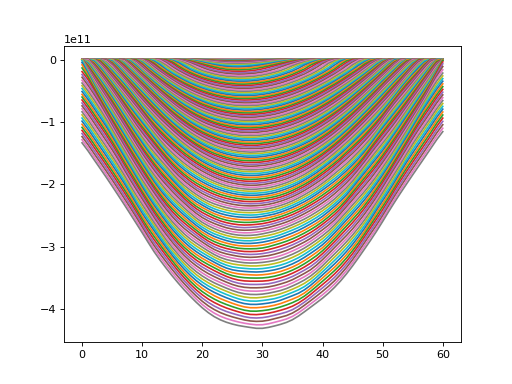

In [13]:
%matplotlib notebook
f6=plt.figure(6)
ax6=f6.add_subplot(111)

ax6.plot(np.transpose(tan_disp)*setup1.p/setup1.el_width);

<IPython.core.display.Javascript object>


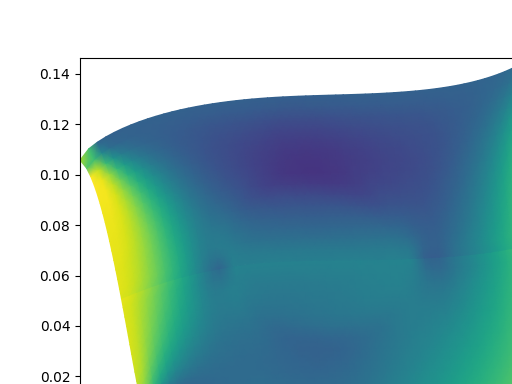

KeyboardInterrupt: 

In [15]:
f7=plt.figure(7)
ax7=f7.add_subplot(111)
f7.show()
f7.canvas.draw()


a=1
for it in range(nt):
    if it % 50 ==0:
#         ax7.clear()
        Utnew=disp_stored[a]*100
#         im=ax7.plot(coord[:,0]+Utnew[::2]*100,coord[:,1]+Utnew[1::2]*1,'xr') #U[::2,0] if not using sparse

#         f7.canvas.draw()   # draw
#         time.sleep(0.1);    
        a=a+1
        
        
        ax7.clear()
        sigma_b=np.zeros((int(nely/2)+1,nelx+1,3))
        sigma_t=np.zeros((int(nely/2)+1,nelx+1,3))
        ux_mat=Utnew[::2].reshape((nely+2, nelx+1))
        uy_mat=Utnew[1::2].reshape((nely+2, nelx+1))
        ux_mat_b=ux_mat[0:int(nely/2)+1,:]
        uy_mat_b=uy_mat[0:int(nely/2)+1,:]
        ux_mat_t=ux_mat[int(nely/2)+1:,:]
        uy_mat_t=uy_mat[int(nely/2)+1:,:]

        ##botom
        Dub=np.gradient(ux_mat_b,setup1.el_heigth,setup1.el_width); #to check width or heigth first
        Dvb=np.gradient(uy_mat_b,setup1.el_heigth,setup1.el_width);
        Dxub=Dub[1]
        Dyub=Dub[0]
        Dxvb=Dvb[1]
        Dyvb=Dvb[0]
        Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
        for i in range(int(nely/2)+1):
            for j in range(nelx+1):
                strain=np.matmul(Bstress,np.array([[Dxub[i,j]],[Dyvb[i,j]],[Dxvb[i,j]],[Dyub[i,j]]]));
                stress=np.matmul(D(E,nu),strain);
                sigma_b[i,j,0]=stress[0]; # 0 for sxx
                sigma_b[i,j,1]=stress[1]; # 1 for syy
                sigma_b[i,j,2]=stress[2]; # 2 for tauxy
        #top
        Dut=np.gradient(ux_mat_t,setup1.el_heigth,setup1.el_width); #to check width or heigth first
        Dvt=np.gradient(uy_mat_t,setup1.el_heigth,setup1.el_width);
        Dxut=Dut[1]
        Dyut=Dut[0]
        Dxvt=Dvt[1]
        Dyvt=Dvt[0]
        Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
        for i in range(int(nely/2)+1):
            for j in range(nelx+1):
                strain=np.matmul(Bstress,np.array([[Dxut[i,j]],[Dyvt[i,j]],[Dxvt[i,j]],[Dyut[i,j]]]));
                stress=np.matmul(D(E,nu),strain);
                sigma_t[i,j,0]=stress[0]; # 0 for sxx
                sigma_t[i,j,1]=stress[1]; # 1 for syy
                sigma_t[i,j,2]=stress[2]; # 2 for tauxy
                
        
        stressmap1=ax7.pcolormesh(((coord[:,0]+Utnew[::2]).reshape((nely+2, nelx+1)))[0:int(nely/2)+1,:], \
                              ((coord[:,1]+Utnew[1::2]).reshape((nely+2, nelx+1)))[0:int(nely/2)+1,:], \
                              sigma_b[:,:,2], shading='Gouraud')

        stressmap2=ax7.pcolormesh(((coord[:,0]+Utnew[::2]).reshape((nely+2, nelx+1)))[int(nely/2)+1:,:], \
                              ((coord[:,1]+Utnew[1::2]).reshape((nely+2, nelx+1)))[int(nely/2)+1:,:], \
                              sigma_t[:,:,2], shading='Gouraud')
        
        stressmap1.set_clim(np.min(sigma_t[:,:,2]),np.max(sigma_t[:,:,2]))
        stressmap2.set_clim(np.min(sigma_t[:,:,2]),np.max(sigma_t[:,:,2]))
        f7.canvas.draw()   # draw
        time.sleep(0.1);

#         ax5.set_aspect('equal')

        
#         # Visualizing colorbar part -start
#         #f5.colorbar(stressmap1,ax=ax5)
#         f5.canvas.draw()   # draw
#         time.sleep(0.1);
        f7.savefig("sim700\\" + 'a' + '{0:05}'.format(it) + '.png')
#     bar.next()

In [66]:
mkdir new_sim

In [67]:
np.save('simul_name',disp_stored)
disp_stored=np.load('simul_name.npy')
disp_stored.shape

(624, 6464)